In [38]:
# From Python
# It requires OpenCV installed for Python
import sys
import os
import cv2
# from sys import platform
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [39]:
import sys
import os
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/./bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/./x64/Release;' +  dir_path + '/./bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e

In [40]:
def extend_hand_box(box, image_height, image_width, extend):
    xmin, ymin, xmax, ymax = box 
    for i in range(extend):
        if xmin == 0 and xmax < image_width: 
            xmax += 1
            extend += 1
        elif xmin > 0 and xmax == image_width: 
            xmin -= 1
            extend += 1
        elif xmin <= 0 and xmax >= image_width:
            pass
        else: 
            xmin, xmax = xmin - 1, xmax + 1

        if ymin == 0 and ymax < image_height: 
            ymax += 1
            extend += 1
        elif ymin > 0 and ymax == image_height:
            ymin -= 1
            extend += 1
        elif ymin <= 0 and ymax >= image_height:
            pass
        else: 
            ymin, ymax = ymin - 1, ymax + 1
    
    xmin = 0 if xmin<0 else xmin
    ymin = 0 if ymin<0 else ymin
    xmax = image_width if xmax > image_width else xmax
    ymax = image_height if ymax > image_height else ymax
    
    return xmin, ymin, xmax, ymax

def find_bounded_sqaure(box):
    xmin, ymin, xmax, ymax = box 
    x = (xmax-xmin)/2 + xmin
    y = (ymax-ymin)/2 + ymin
    extend = max(xmax-xmin, ymax-ymin)/2 
    new_xmin, new_ymin = x-extend, y-extend
    new_xmax, new_ymax = x+extend, y+extend
    return new_xmin, new_ymin, new_xmax, new_ymax

def convert_to_op_rectangle(box, image_height, image_width, extend=50):
    bounded_sqaure = find_bounded_sqaure(box)
#     print(bounded_sqaure)
    xmin, ymin, xmax, ymax = extend_hand_box(bounded_sqaure, image_height, image_width, extend)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)
    length = max(width, height)
    hand_rectangle = op.Rectangle(xmin, ymin, length, length)
    return hand_rectangle

In [41]:
# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = "openpose/models/"
params["hand"] = True
params["hand_detector"] = 2
params["body"] = 0

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

In [52]:
# Read image and face rectangle locations
image_path = r'D:\PuMuxin\HandDB\original\naked_hands\00000001.jpg'

# image_path = r'D:\PuMuxin\FreiHand\orginal\naked_hands\00000527.jpg'#00000057.jpg'
imageToProcess = cv2.imread(image_path)

# From body pose 
hand_boxes = [[ 50.7659, 107.6273, 283.7699, 227.8340], [ 50.7659, 107.6273, 283.7699, 227.8340]]

# Convert to openpose hands rectangles
height, width = imageToProcess.shape[:2]
handRectangles = [[convert_to_op_rectangle(box, height, width, 30), convert_to_op_rectangle(box, height, width, 30)] for box in hand_boxes]

# Create new datum
datum = op.Datum()
datum.cvInputData = imageToProcess
datum.handRectangles = handRectangles

# Process and display image
opWrapper.emplaceAndPop(op.VectorDatum([datum]))
print("Left hand keypoints: \n" + str(datum.handKeypoints[0]))
print("Right hand keypoints: \n" + str(datum.handKeypoints[1]))

keypoints = datum.handKeypoints

Left hand keypoints: 
[[[7.88889694e+01 1.65342026e+02 3.13656151e-01]
  [7.80927658e+01 1.47029282e+02 5.18593311e-01]
  [7.41117325e+01 1.31105148e+02 7.25983560e-01]
  [1.01182755e+02 1.24735497e+02 8.12586010e-01]
  [1.34623428e+02 1.27124115e+02 7.53906548e-01]
  [1.72045135e+02 2.02763733e+02 3.44260007e-01]
  [2.23798553e+02 2.19484070e+02 8.00822198e-01]
  [2.53258194e+02 2.09133392e+02 7.49600351e-01]
  [2.80329224e+02 1.96394089e+02 8.22414756e-01]
  [1.61694443e+02 2.02763733e+02 5.82053423e-01]
  [1.94338913e+02 2.09929596e+02 4.82515931e-01]
  [2.48480957e+02 1.89228226e+02 4.86426830e-01]
  [2.48480957e+02 1.62953415e+02 7.68790722e-01]
  [1.44974106e+02 2.00375122e+02 7.30738223e-01]
  [1.93542709e+02 2.10725800e+02 4.74011958e-01]
  [2.19817520e+02 2.03559952e+02 5.23556411e-01]
  [2.47684753e+02 1.90024429e+02 2.49433175e-01]
  [1.32234802e+02 1.98782700e+02 4.14261788e-01]
  [1.52139969e+02 1.84450989e+02 5.55562079e-01]
  [1.70452728e+02 1.78081329e+02 5.77739418e-01

In [53]:
def get_predicted_keypoints_coordinates(keypoints):
    no = 0
    coordinates = []
    for hand_list in keypoints:
        for hand in hand_list:
            this_hand = []
            no += 1
            print("hand no: " + str(no))
            for i in range(21):
                this_hand.append(list(hand[i,:2]))
                print(str(i) + ': ' + str(list(hand[i,:2])))
            coordinates.append(this_hand)
    return coordinates

coordinates = get_predicted_keypoints_coordinates(keypoints)

hand no: 1
0: [78.88897, 165.34203]
1: [78.092766, 147.02928]
2: [74.11173, 131.10515]
3: [101.182755, 124.7355]
4: [134.62343, 127.124115]
5: [172.04514, 202.76373]
6: [223.79855, 219.48407]
7: [253.2582, 209.13339]
8: [280.32922, 196.39409]
9: [161.69444, 202.76373]
10: [194.33891, 209.9296]
11: [248.48096, 189.22823]
12: [248.48096, 162.95341]
13: [144.9741, 200.37512]
14: [193.54271, 210.7258]
15: [219.81752, 203.55995]
16: [247.68475, 190.02443]
17: [132.2348, 198.7827]
18: [152.13997, 184.45099]
19: [170.45273, 178.08133]
20: [195.93134, 163.74962]
hand no: 2
0: [78.88897, 165.34203]
1: [78.092766, 147.02928]
2: [74.11173, 131.10515]
3: [101.182755, 124.7355]
4: [134.62343, 127.124115]
5: [172.04514, 202.76373]
6: [223.79855, 219.48407]
7: [253.2582, 209.13339]
8: [280.32922, 196.39409]
9: [161.69444, 202.76373]
10: [194.33891, 209.9296]
11: [248.48096, 189.22823]
12: [248.48096, 162.95341]
13: [144.9741, 200.37512]
14: [193.54271, 210.7258]
15: [219.81752, 203.55995]
16: [247.68

# Prediction

In [68]:
def annotate_image(points, oriImg):
    edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], \
             [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

    plt.imshow(oriImg[:, :, [2, 1, 0]])

    for i, (x, y) in enumerate(points):
        plt.plot(x, y, 'r.')
        plt.text(x, y, str(i))

    for ie, e in enumerate(edges):
        rgb = matplotlib.colors.hsv_to_rgb([ie / float(len(edges)), 1.0, 1.0])
        x1, y1 = points[e[0]]
        x2, y2 = points[e[1]]
        plt.plot([x1, x2], [y1, y2], color=rgb)
    plt.axis('off')
    plt.show()

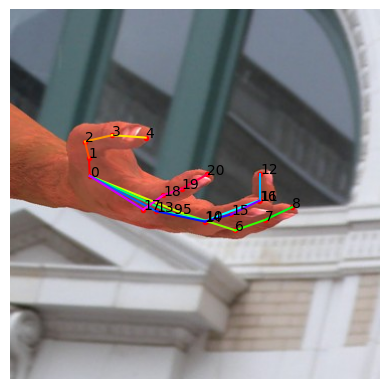

In [55]:
# Provide the same hand rectangle for both right and left, then caculate using the highest average key error
annotate_image(coordinates[0], imageToProcess)

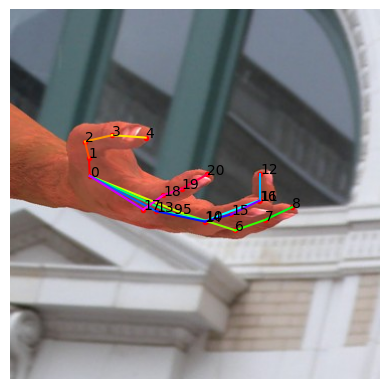

In [59]:
annotate_image(coordinates[0], imageToProcess)

# Bechmark 

In [12]:
import json

def projectPoints(xyz, K):
    """ Project 3D coordinates provided by the hands dataset into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def read_json_data(file_path):
    with open(file_path) as file:
        content = json.load(file)
    return content

In [13]:
dataset_dir=r'D:\PuMuxin\FreiHand'
xyz_array = read_json_data(f'{dataset_dir}\\training_xyz.json')
k_array = read_json_data(f'{dataset_dir}\\training_k.json')

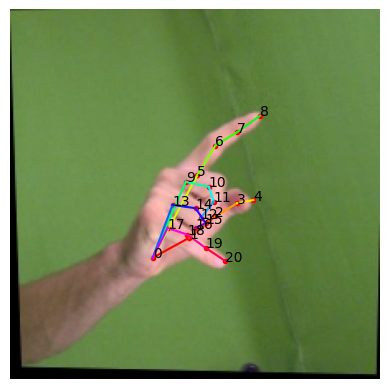

In [15]:
image_path = r'D:\PuMuxin\FreiHand\orginal\naked_hands\00000010.jpg'#00000057.jpg'
index = 10
image = cv2.imread(image_path)
actual_coordinate = projectPoints(xyz_array[index], k_array[index]).astype(np.int32)
annotate_image(actual_coordinate, image)

# Check if the selected images from HandDB contains only left hands

In [29]:
# HandDB contains only left hand

In [7]:
sys.path.insert(0, '../')
from functions import *
import json

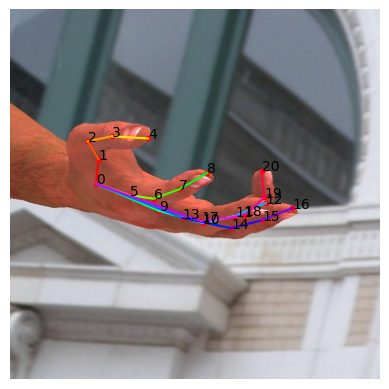

In [70]:
image_path = r'D:\PuMuxin\HandDB\original\naked_hands\00000001.jpg'
image = cv2.imread(image_path)

baseline = read_json_data(r'D:\PuMuxin\HandDB\xyz\00000001.json')
actual_coordinate = [[coordinate[i] for i in range(2)] for coordinate in baseline['hand_pts']]
annotate_image(actual_coordinate, image)

In [30]:
filename = '00000001.json'
file = read_json_data(r'D:\PuMuxin\HandDB\xyz\\' +  filename)
file

{'hand_pts': [[85.21452331542969, 173.12060546875, 1.0],
  [87.69029235839844, 148.85780334472656, 1.0],
  [76.8404541015625, 130.8544921875, 1.0],
  [101.13573455810547, 125.7907485961914, 1.0],
  [137.0382843017578, 128.0027618408203, 1.0],
  [118.55326080322266, 184.5325469970703, 1.0],
  [142.43692016601562, 187.96066284179688, 1.0],
  [167.59210205078125, 178.7992401123047, 1.0],
  [196.06517028808594, 162.23907470703125, 1.0],
  [147.82598876953125, 200.0380096435547, 1.0],
  [191.43353271484375, 212.16567993164062, 1.0],
  [223.47140502929688, 205.14064025878906, 1.0],
  [254.2811737060547, 192.2958984375, 1.0],
  [171.59661865234375, 207.18063354492188, 1.0],
  [219.7498321533203, 217.37692260742188, 1.0],
  [250.63174438476562, 209.32655334472656, 1.0],
  [280.5866394042969, 197.31211853027344, 1.0],
  [189.6280975341797, 210.22674560546875, 1.0],
  [232.78018188476562, 204.87371826171875, 1.0],
  [252.8502197265625, 186.2230224609375, 1.0],
  [249.9256134033203, 160.247802734

In [31]:
file['hand_pts']

[[85.21452331542969, 173.12060546875, 1.0],
 [87.69029235839844, 148.85780334472656, 1.0],
 [76.8404541015625, 130.8544921875, 1.0],
 [101.13573455810547, 125.7907485961914, 1.0],
 [137.0382843017578, 128.0027618408203, 1.0],
 [118.55326080322266, 184.5325469970703, 1.0],
 [142.43692016601562, 187.96066284179688, 1.0],
 [167.59210205078125, 178.7992401123047, 1.0],
 [196.06517028808594, 162.23907470703125, 1.0],
 [147.82598876953125, 200.0380096435547, 1.0],
 [191.43353271484375, 212.16567993164062, 1.0],
 [223.47140502929688, 205.14064025878906, 1.0],
 [254.2811737060547, 192.2958984375, 1.0],
 [171.59661865234375, 207.18063354492188, 1.0],
 [219.7498321533203, 217.37692260742188, 1.0],
 [250.63174438476562, 209.32655334472656, 1.0],
 [280.5866394042969, 197.31211853027344, 1.0],
 [189.6280975341797, 210.22674560546875, 1.0],
 [232.78018188476562, 204.87371826171875, 1.0],
 [252.8502197265625, 186.2230224609375, 1.0],
 [249.9256134033203, 160.247802734375, 1.0]]

In [12]:
file['is_left']

0